In [42]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from low_dim_capability_space import * 
from utils import *

In [131]:
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

MODELS_PART_4_3 = ['Llama-2', 
                   'llama-', 
                   'Llama-3',
                   'Qwen1.5',
                   'Qwen-',
                   'Mistral',
                   'Mixtral',
                   'Yi',
                   'gemma',
                   'falcon',
                   'phi',
                   'pythia',
                   'bloom',
                   'gpt-',
                   'opt',
                   'mpt',
                   'xglm',
                   'CodeLlama',
                   'starcoderbase',
                   'starcoder2',
                   'deepseek-coder-'
]



def load_eval_scores(models_names: list = None):
    
    evals = pd.read_csv('leaderboards/base_llm_post_training_eval.csv')

    # Add metadata from the other leaderboard
    evals_compute = pd.read_csv('leaderboards/base_llm_benchmark_eval.csv')
    evals = evals.merge(evals_compute, on=['Model'])
    
    # PCA Imputation
    imputed_evals, _ = pca_imputation(evals,
                                      benchmarks=remove_str_cols_from_df(evals).columns.tolist())
    
    # Remerge and remove duplicate columns
    compute_col = evals['FLOPs (1E21)']
    evals = imputed_evals.merge(evals, left_index=True, right_index=True,
                                how='outer', suffixes=('', '_y'))
    evals.drop(evals.filter(regex='_y$').columns, axis=1, inplace=True)

    evals['log_compute'] = np.log10(compute_col)

    if models_names:
        pattern = '|'.join(models_names)
        evals = evals[evals['Model'].str.contains(pattern, regex=True)]
        print(f"Loaded eval scores for {evals.shape[0]} models")
    return evals


def split_train_test(evals: pd.DataFrame,
                     flops_cutoff: float = 84 
):
    evals['set'] = None
    for i, row in evals.iterrows():
        if row['FLOPs (1E21)'] > flops_cutoff:
            evals.loc[i, 'set'] = 'test'
        else:
            evals.loc[i, 'set'] = 'train'

    return evals


def remove_str_cols_from_df(df: pd.DataFrame):
    return df.select_dtypes(exclude=['object'])


def remove_nan_rows(evals: pd.DataFrame,
                    row: str = 'log_compute'):
    evals = evals.dropna(subset=[row])
    return evals


def sigmoid(x, L ,x0, k, b):
    return L / (1 + np.exp(-k*(x-x0)))+b

def sigmoid_2_params(x, x0, k):
    return 1 / (1 + np.exp(-k*(x-x0)))
    

def fit_sigmoid(evals: pd.DataFrame,
                benchmark: 'str' = 'gsm8k_5_exact_match,flexible-extract',
                sigmoid_n_params: int = 4
):

    train_set = evals[evals['set'] == 'train']
    eval_scores = train_set[benchmark]
    # Set the initial parameters for the sigmoid function
    L_init = max(eval_scores)  # Maximum value of target data
    x0_init = np.median(eval_scores)  # Median value of feature data
    k_init = 1  # Initial guess for the steepness
    b_init = min(eval_scores)  # Minimum value of target data
    
    # Remove rows with NaN values for log_compute
    train_set = remove_nan_rows(train_set, row='log_compute')

    if sigmoid_n_params == 4:
        params, _ = curve_fit(sigmoid, train_set['log_compute'].values, 
                              train_set[benchmark].values, 
                              [L_init, x0_init, k_init, b_init], 
                              maxfev=10000)
        L, x0, k, b = params
        print(f"Fitted parameters: L = {L}, x0 = {x0}, k = {k}, b = {b}")
    elif sigmoid_n_params == 2:
        params, _ = curve_fit(sigmoid_2_params, train_set['log_compute'].values, 
                              train_set[benchmark].values, 
                              [x0_init, k_init], 
                              maxfev=10000)
        x0, k = params
        print(f"Fitted parameters: x0 = {x0}, k = {k}")

    return params


In [11]:
evals = split_train_test(load_eval_scores(models_names=MODELS_PART_4_3))

Missing values in training data: 2.62%
Loaded eval scores for 77 models


Fitted parameters: x0 = 6.473500707489286, k = 0.60925723728559
Fitted parameters: x0 = 3.1687184082399997, k = 1.1344146430331075


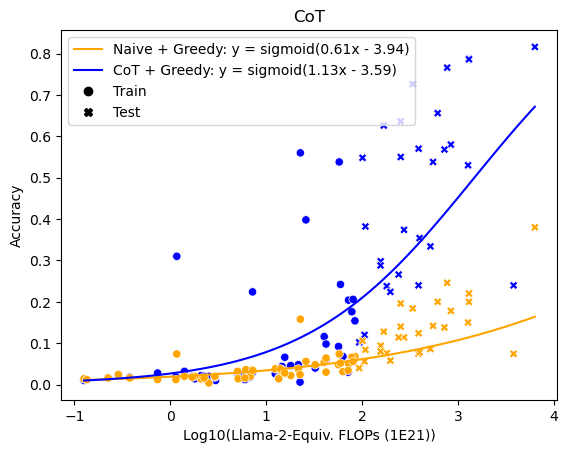

In [20]:
def plot_post_training_prediction(evals: pd.DataFrame,
                                  dataset1: str = 'gsm8k_5_exact_match,flexible-extract',
                                  dataset2: str = 'gsm8k_cot_8_exact_match,flexible-extract',
                                  sigmoid_n_params: int = 4
):
    """ Plots the post-training prediction of the two datasets.
    Legend is not yet compatible with sigmoid_n_params = 4.
    """

    fig, ax = plt.subplots()
    handles, labels = ax.get_legend_handles_labels()
    sns.scatterplot(data=evals, x="log_compute", y=dataset2, style='set', color='blue')
    sns.scatterplot(data=evals, x="log_compute", y=dataset1, style='set', color='orange')

    # Sigmoids
    params1 = fit_sigmoid(evals, benchmark=dataset1, sigmoid_n_params=sigmoid_n_params)
    params2 = fit_sigmoid(evals, benchmark=dataset2, sigmoid_n_params=sigmoid_n_params)
    x = np.linspace(min(evals['log_compute']), max(evals['log_compute']), 100)

    if sigmoid_n_params == 4:
        y1 = sigmoid(x, *params1)
        y2 = sigmoid(x, *params2)
        sns.lineplot(x=x, y=y1, color='orange')
        sns.lineplot(x=x, y=y2, color='blue')
        custom_handles = [plt.Line2D([], [], color='orange', label=f'Naive + Greedy: y = {params1[0]:.2f} sigmoid({params1[2]:.2f}x - {params1[2]*params1[1]:.2f}) + {params1[3]:.2f}'),
                          plt.Line2D([], [], color='blue', label=f'CoT + Greedy: y = {params2[0]:.2f} sigmoid({params2[2]:.2f}x - {params2[2]*params2[1]:.2f}) + {params2[3]:.2f}')]

    elif sigmoid_n_params == 2:
        y1 = sigmoid_2_params(x, *params1)
        y2 = sigmoid_2_params(x, *params2)
        sns.lineplot(x=x, y=y1, color='orange')
        sns.lineplot(x=x, y=y2, color='blue')
        custom_handles = [plt.Line2D([], [], color='orange', label=f'Naive + Greedy: y = sigmoid({params1[1]:.2f}x - {params1[0]*params1[1]:.2f})'),
                          plt.Line2D([], [], color='blue', label=f'CoT + Greedy: y = sigmoid({params2[1]:.2f}x - {params2[0]*params2[1]:.2f})')]
    
    

    scatter_handles = [plt.Line2D([], [], marker='o', color='black', linestyle='None', markersize=6, label='Train'),
                       plt.Line2D([], [], marker='X', color='black', linestyle='None', markersize=6, label='Test')]

    # Combine all legends
    ax.legend(handles=custom_handles + scatter_handles, loc='best')

    plt.xlabel('Log10(Llama-2-Equiv. FLOPs (1E21))')
    plt.ylabel('Accuracy')
    plt.title('CoT')

    return


plot_post_training_prediction(evals=evals,
                              sigmoid_n_params=2)


In [190]:


def linear_correlation_metric_pcs(leaderboard: pd.DataFrame,
                                  reference_family: str = 'Llama-2',
                                  benchmarks: list = BENCHMARKS,
                                  benchmark_to_remove: str = 'GSM8K',
                                  target_metric: str = 'gsm8k_cot_8_exact_match,flexible-extract',
                                  n_pcs: int = 3,
                                  pca_n_components: int = 5,
                                  standardize_pca: bool = False
):
    # Remove the target metric before applying PCA
    if benchmark_to_remove in benchmarks:
        benchmarks.remove(benchmark_to_remove)
    principal_df, explained_variance, pca_components = apply_pca(leaderboard, 
                                                                benchmarks=benchmarks,
                                                                n_components=pca_n_components, 
                                                                standardize=standardize_pca)
    leaderboard = pd.concat([leaderboard, principal_df], axis=1)
    
    # Get PCs
    pcs_col_names = [f'PC-{i+1}' for i in range(n_pcs)]
    pcs = leaderboard[pcs_col_names].values
    
    # Get target metric
    target_metric_values = leaderboard[target_metric].values

    # Fit linear regressions to get w_f and b_f (only on reference family): P_m = w_f * log(C_m) + b_f (links target metric and log_compute)
    reference_family_leaderboard = leaderboard[leaderboard['Model'].str.contains(reference_family)]
    reference_family_target_metric_values = reference_family_leaderboard[target_metric].values
    reference_family_log_compute_values = reference_family_leaderboard['log_compute'].values

    model1 = LinearRegression()
    model1.fit(reference_family_log_compute_values.reshape(-1, 1), reference_family_target_metric_values)
    w_f = model1.coef_ #scalar
    b_f = model1.intercept_ #scalar

    # Fit linear regression to get beta and alpha (on all models): P_m = beta * S_m + alpha (links target metric and PCs)
    model2 = LinearRegression()
    model2.fit(pcs, target_metric_values)
    beta = model2.coef_
    alpha = model2.intercept_
    
    return target_metric, w_f, b_f, beta, alpha, pca_components[0:n_pcs]


leaderboard = load_eval_scores(models_names=MODELS_PART_4_3)
target_metric, w_f, b_f, beta, alpha, pca_components = linear_correlation_metric_pcs(leaderboard=leaderboard)

Missing values in training data: 2.55%
Loaded eval scores for 77 models


In [191]:
pca_components

,MMLU,ARC-C,HellaSwag,Winograd,TruthfulQA,XWinograd,HumanEval
PC-1,0.511762,0.426985,0.478391,0.301470,0.083176,0.263462,0.399638
PC-2,0.240314,-0.186686,-0.525692,-0.233630,0.196045,-0.105353,0.725899
PC-3,0.652351,-0.007136,-0.266590,-0.002466,0.446956,-0.083822,-0.544532


In [192]:
beta

array([0.71413498, 0.52377424, 0.6484085 ])

<Axes: >

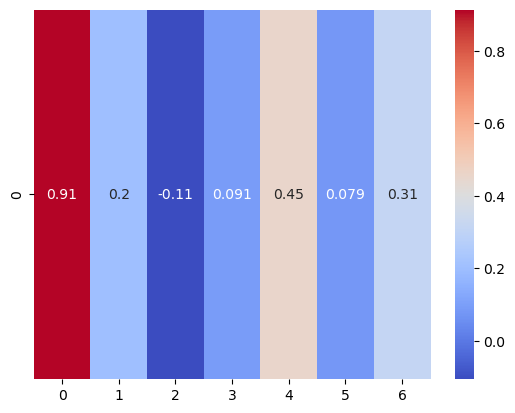

In [193]:
weights = np.einsum('kb, k -> b', pca_components.to_numpy(), beta)
sns.heatmap(weights.reshape(1, -1), annot=True, cmap='coolwarm')